In [375]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [376]:
df = pd.read_csv('/Users/dophi/Desktop/Crypto_dashboard_predict/feature_engineering/BTCUSDT_1d_fe.csv')
df.head(5)

,open_time,open,high,low,close,volume,rsi,pct_change
0,2017-08-31,4555.14,4745.42,4555.14,4724.89,556.956802,36.960842,3.726559
1,2017-09-01,4689.89,4885.55,4654.88,4834.91,560.666366,41.058493,2.328520
2,2017-09-02,4796.16,4939.19,4286.87,4472.14,929.148595,33.358714,-7.503139
3,2017-09-03,4508.50,4714.76,4298.33,4509.08,691.216198,34.701566,0.826003
4,2017-09-04,4505.00,4527.49,3972.51,4100.11,1394.644614,27.979485,-9.069921


# Chia tập dữ liệu train/test

In [377]:
y = df['close']
y

0        4724.89
1        4834.91
2        4472.14
3        4509.08
4        4100.11
          ...   
3023    92015.37
3024    92513.38
3025    90268.42
3026    90240.01
3027    88172.17
Name: close, Length: 3028, dtype: float64

In [378]:
X = df.drop(['close','open_time'], axis=1)
X

,open,high,low,volume,rsi,pct_change
0,4555.14,4745.42,4555.14,556.956802,36.960842,3.726559
1,4689.89,4885.55,4654.88,560.666366,41.058493,2.328520
2,4796.16,4939.19,4286.87,929.148595,33.358714,-7.503139
3,4508.50,4714.76,4298.33,691.216198,34.701566,0.826003
4,4505.00,4527.49,3972.51,1394.644614,27.979485,-9.069921
...,...,...,...,...,...,...
3023,92678.81,94476.00,91563.15,18998.680830,48.388995,-0.715838
3024,92015.38,93555.00,89260.63,19972.587580,49.557568,0.541225
3025,92513.38,92754.00,89480.00,16679.191690,44.649756,-2.426633
3026,90268.43,90634.55,89766.39,5895.707880,44.589575,-0.031473


In [379]:
sequence_length = 30
test_days = 30

N = len(df)
test_start = N - test_days #toàn bộ dữ liệu - 30 ngày cuối
window_start = test_start - sequence_length #lấy thêm 30 ngày trước đó để tạo chuỗi đủ độ dài

In [380]:
# Tập Train : từ đầu tới trước ngày test_start
train_X = X.iloc[:test_start]
train_y = y.iloc[:test_start]

In [381]:
# Tập Test  30 ngày lookback + 30 ngày test
test_X = X.iloc[window_start:]
test_y = y.iloc[window_start:]

In [382]:
print("Train X shape:", train_X.shape)
print("Train y shape:", train_y.shape)
print("Test X shape:", test_X.shape)
print("Test y shape:", test_y.shape)

Train X shape: (2998, 6)
Train y shape: (2998,)
Test X shape: (60, 6)
Test y shape: (60,)


# Scale

In [383]:
scaler_X = StandardScaler()
scaled_train_X = scaler_X.fit_transform(train_X)
scaled_test_X  = scaler_X.transform(test_X)

In [ ]:
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(train_y.to_numpy().reshape(-1, 1))
y_test_scaled  = scaler_y.transform(test_y.to_numpy().reshape(-1, 1))

# Lưu model scaler

In [385]:
import pickle

with open("scaler_X_BTC.pkl", "wb") as f:
    pickle.dump(scaler_X, f)

with open("scaler_y_BTC.pkl", "wb") as f:
    pickle.dump(scaler_y, f)

In [386]:
scaled_train_X

array([[-0.9695539 , -0.9716802 , -0.96038752, -0.81381409, -1.1347949 ,
         0.98806314],
       [-0.96529213, -0.96731943, -0.95717745, -0.8137661 , -0.8359096 ,
         0.6000019 ],
       [-0.96193111, -0.96565018, -0.96902163, -0.80899916, -1.39753646,
        -2.12902341],
       ...,
       [ 2.14584772,  2.15856251,  2.13763217, -0.55636479, -0.99422123,
        -0.42465279],
       [ 2.10142321,  2.11971545,  2.04709136, -0.35272978, -1.19467519,
        -0.58217278],
       [ 2.03935988,  1.9884227 ,  1.91874161, -0.20926639, -1.6298278 ,
        -1.46579358]])

# Tạo sequences(chuỗi) và label(nhãn) cho tập train và test 

In [387]:
# Tạo chuỗi và nhãn cho tập train
sequence_length = 30 
X_train, y_train = [], []
for i in range(len(scaled_train_X) - sequence_length):
    X_train.append(scaled_train_X[i:i + sequence_length])
    y_train.append(y_train_scaled[i + sequence_length])
# Sau chuỗi
X_train, y_train = np.array(X_train), np.array(y_train)

In [388]:
# Chuyển đổi dữ liệu sang Pytorch Tensors
import torch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

torch.Size([2968, 30, 6]) torch.Size([2968, 1])


kết quả: 2968: số mẫu huấn luyện trên tập train, 30 độ dài chuỗi, 6 số đặc trưng

In [389]:
# Tạo chuỗi và nhãn cho tập test
sequence_length = 30
X_test, y_test = [], []
for i in range(len(scaled_test_X) - sequence_length):
    X_test.append(scaled_test_X[i:i + sequence_length])
    y_test.append(y_test_scaled[i + sequence_length])
#sau chuỗi
X_test, y_test = np.array(X_test), np.array(y_test)

In [390]:
# Chuyển đổi dữ liệu sang Pytorch Tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)

torch.Size([30, 30, 6]) torch.Size([30, 1])


kết quả: 30: số mẫu huấn luyện trên tập test, 30 độ dài chuỗi, 6 số đặc trưng

# khai báo mô hình LSTM

In [391]:
import torch.nn as nn
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out

# Kiểm tra thiết bị nếu có gpu cuda thì sử dụng nếu không dùng cpu

In [392]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Khởi tạo tham số cho mô hình

In [393]:
input_size = 6
num_layers = 2
hidden_size = 256
output_size = 1
dropout = 0.4
# sử dụng thiết bị tương ứng
model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout).to(device)

# Sử dụng chỉ số MSE cho loss và khởi tạo thêm optimizer là adam

In [394]:
import torch.optim as optim
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-3)

khi huấn luyện mô hình sử dụng mse làm loss để trong quá trình huấn luyện, mô hình sẽ cố găng tập trung tối thiểu hoá các sai số lớn, vì vậy em chọn mse làm loss để bình phương sai số giữa giá trị dự đoán và giá trị thực tế.


# Tạo dataloader

In [395]:
from torch.utils.data import DataLoader, TensorDataset
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

TensorDataset sẽ giúp ghép X, y thành cặp input và target
còn Dataloader sẽ chia dữ liệu thành 32 batch ngoài ra shuffle tức là trộn dữ liệu sẽ áp dụng cho tập train điều này giúp mô hình không học vẹt, học theo thứ tự

# vòng lặp training

In [396]:
num_epochs = 250
train_hist = []
test_hist = []

In [397]:
#early stopping và lưu mô hình tốt nhất
best_loss = float('inf')   # lưu test loss thấp nhất
patience = 25               # cho phép 15 epoch không cải thiện
patience_counter = 0

for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0

        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)

            total_test_loss += test_loss.item()

        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')
    # Early stopping và lưu mô hình tốt nhất
    if average_test_loss < best_loss:
        best_loss = average_test_loss
        torch.save(model.state_dict(), 'best_model_btc.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Stop early tại epoch {epoch+1} (test loss không cải thiện trong {patience} epoch)")
            break

Epoch [10/250] - Training Loss: 0.0039, Test Loss: 0.0069
Epoch [20/250] - Training Loss: 0.0028, Test Loss: 0.0088
Epoch [30/250] - Training Loss: 0.0026, Test Loss: 0.0063
Epoch [40/250] - Training Loss: 0.0027, Test Loss: 0.0158
Epoch [50/250] - Training Loss: 0.0026, Test Loss: 0.0109
Epoch [60/250] - Training Loss: 0.0027, Test Loss: 0.0108
Stop early tại epoch 62 (test loss không cải thiện trong 25 epoch)


# Dự báo trên tập test

In [398]:
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test).numpy()

In [399]:
# chuyển scale về dạng ban đầu
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test.cpu().numpy())

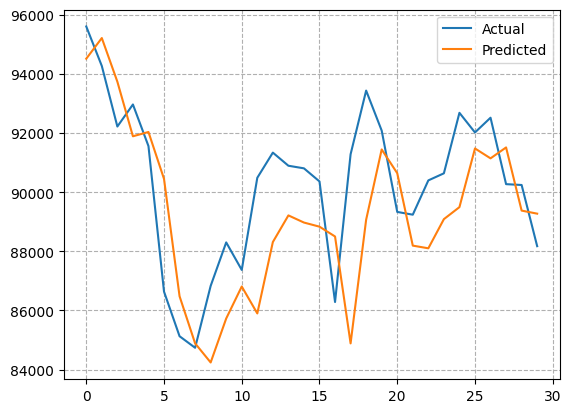

In [400]:
plt.plot(y_true, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.grid(ls ='--')
plt.show()

# Đánh giá mô hình qua các chỉ số MSE, MAE, R2 Score

In [401]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
print("MSE:",mean_squared_error(y_true,y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_true,y_pred)))
print("MAE:",mean_absolute_error(y_true,y_pred))

MSE: 5528948.5
RMSE: 2351.3716209906083
MAE: 1895.99267578125
